In [1]:
# %pip install --quiet "torch>=2.0" "torchvision" Pillow matplotlib
# %pip install --quiet git+https://github.com/openai/CLIP.git
# %pip install --quiet lpips

In [11]:
import os
import json
from pathlib import Path

ROOT = Path("/Users/ninachely/_hse/ai_project/")

os.chdir(ROOT)

DATA_DIR = ROOT / "data"
IMG_DIR = DATA_DIR / "annotation_images"

with open(DATA_DIR / "mapping_file.json", "r", encoding="utf-8") as f:
    mapping_main = json.load(f)

with open(DATA_DIR / "mapping_file_ti2i_benchmark.json", "r", encoding="utf-8") as f:
    mapping_ti2i = json.load(f)

print("main samples:", len(mapping_main))
print("ti2i samples:", len(mapping_ti2i))

main samples: 700
ti2i samples: 223


In [15]:
CAND_EXT = [".jpg", ".jpeg", ".png", ".webp"]

def resolve_image_path(rel_path: str) -> Path:
    # json: "data/annotation_images/0_random_140/000000000000.jpg"
    parts = Path(rel_path).parts
    p = Path(*parts)

    full = IMG_DIR / p if "data" not in parts else ROOT / p
    if full.exists():
        return full

    # если такого файла нет — пробуем подставить другие расширения
    parent = (IMG_DIR / p).parent
    stem = p.stem
    for ext in CAND_EXT:
        cand = parent / f"{stem}{ext}"
        if cand.exists():
            return cand

    # если и так нет — просто возьмём первый файл в папке как fallback
    imgs = sorted(parent.glob("*"))
    if imgs:
        return imgs[0]

    raise FileNotFoundError(f"Не нашёл файл ни по {p}, ни по вариантам расширений.")

In [16]:
def show_some(mapping, n=5, title="main"):
    print(f"=== {title} ===")
    for i, (k, v) in enumerate(mapping.items()):
        print("ID:", k)
        print(" image_path:", resolve_image_path(v["image_path"]))
        print(" original_prompt:", v.get("original_prompt", ""))
        print(" editing_prompt:", v.get("editing_prompt", ""))
        print(" instruction:", v.get("editing_instruction", ""))
        print(" editing_type_id:", v.get("editing_type_id", ""))
        print()
        if i + 1 >= n:
            break

show_some(mapping_main, title="PIE-Bench main")
show_some(mapping_ti2i, title="PIE-Bench ti2i")

=== PIE-Bench main ===
ID: 000000000000
 image_path: /Users/ninachely/_hse/ai_project/data/annotation_images/0_random_140/000000000000.jpg
 original_prompt: a slanted mountain bicycle on the road in front of a building
 editing_prompt: a slanted [rusty] mountain bicycle on the road in front of a building
 instruction: Make the frame of the bike rusty
 editing_type_id: 0

ID: 000000000001
 image_path: /Users/ninachely/_hse/ai_project/data/annotation_images/0_random_140/000000000001.jpg
 original_prompt: a [round] cake with orange frosting on a wooden plate
 editing_prompt: a [square] cake with orange frosting on a wooden plate
 instruction: Change the cake shape to square
 editing_type_id: 0

ID: 000000000002
 image_path: /Users/ninachely/_hse/ai_project/data/annotation_images/0_random_140/000000000002.jpg
 original_prompt: a [cat] sitting on a wooden chair
 editing_prompt: a [dog] sitting on a wooden chair
 instruction: Change the animal from a cat to a dog
 editing_type_id: 0

ID: 000

In [23]:
import json
from pprint import pprint

# посмотрим, что именно лежит в этом sample
pprint(sample)

{'blended_word': 'bicycle bicycle',
 'editing_instruction': 'Make the frame of the bike rusty',
 'editing_prompt': 'a slanted [rusty] mountain bicycle on the road in front of '
                   'a building',
 'editing_type_id': '0',
 'image_path': '0_random_140/000000000000.jpg',
 'mask': [0,
          513,
          1023,
          2,
          1535,
          2,
          2047,
          2,
          2559,
          2,
          3071,
          2,
          3583,
          2,
          4095,
          2,
          4607,
          2,
          5119,
          2,
          5631,
          2,
          6143,
          2,
          6655,
          2,
          7167,
          2,
          7679,
          2,
          8191,
          2,
          8703,
          2,
          9215,
          2,
          9727,
          2,
          10239,
          2,
          10751,
          2,
          11263,
          2,
          11775,
          2,
          11950,
          24,
          12287,

PIE-Bench — небольшой eval-набор для текстового редактирования изображений.
В каждой записи есть: исходное изображение, исходный промпт, редактирующий промпт,
текстовая инструкция, тип правки и RLE-маска редактируемой области.
Это позволяет отдельно проверять:
1) соответствие результата целевому тексту (CLIP),
2) сохранение не редактируемых областей (LPIPS по фону),
3) локальность правки.
Набор покрывает разные классы правок (объект, атрибут, фон, стиль), но он компактный,
поэтому используется именно для сравнения методов, а не для обучения.

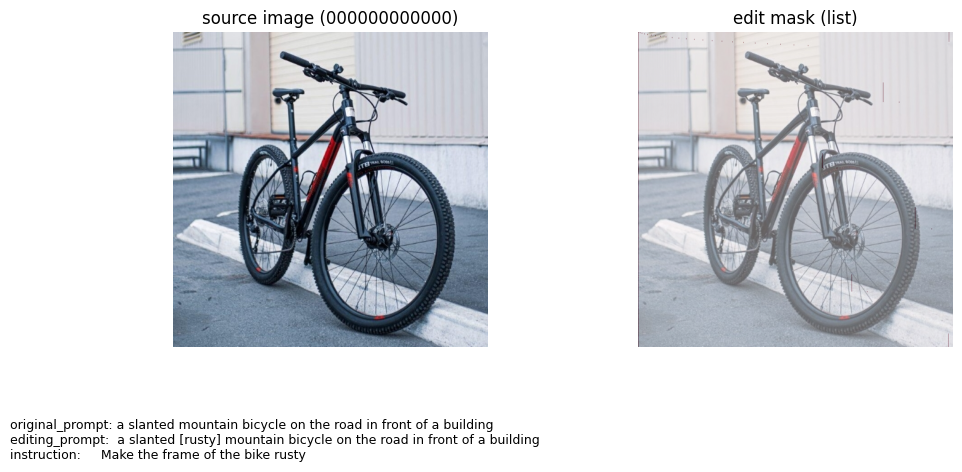

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def decode_coco_mask(mask_dict):
    counts = mask_dict["counts"]
    h, w = mask_dict["size"]
    arr = np.zeros(h * w, dtype=np.uint8)
    idx = 0
    val = 0
    for c in counts:
        arr[idx:idx+c] = val
        idx += c
        val = 1 - val
    return arr.reshape((h, w), order="F")

def decode_list_mask(mask_list, target_hw):
    # предполагаем исходный размер 512x512, потом ресайзим
    h, w = 512, 512
    arr = np.zeros(h * w, dtype=np.uint8)
    idx = 0
    val = 0
    for c in mask_list:
        arr[idx:idx+c] = val
        idx += c
        val = 1 - val
    mask = arr.reshape((h, w), order="F")
    H, W = target_hw
    if (h, w) != (H, W):
        mask = np.array(
            Image.fromarray(mask * 255).resize((W, H), Image.NEAREST)
        ) // 255
    return mask

good_sample = None
good_img_path = None

# 1) пробуем найти dict-маску
for _id, item in mapping_main.items():
    m = item.get("mask")
    if not isinstance(m, dict):
        continue
    try:
        img_path = resolve_image_path(item["image_path"])
        Image.open(img_path).close()
    except Exception:
        continue
    good_sample = item
    good_img_path = img_path
    good_id = _id
    mask_type = "dict"
    break

# 2) если dict не нашли — берём первую list-маску
if good_sample is None:
    for _id, item in mapping_main.items():
        m = item.get("mask")
        if not isinstance(m, list):
            continue
        try:
            img_path = resolve_image_path(item["image_path"])
            Image.open(img_path).close()
        except Exception:
            continue
        good_sample = item
        good_img_path = img_path
        good_id = _id
        mask_type = "list"
        break

if good_sample is None:
    raise RuntimeError("вообще не нашёл сэмпл с маской и существующей картинкой")

# --- визуализация ---
img = Image.open(good_img_path).convert("RGB")

if mask_type == "dict":
    mask = decode_coco_mask(good_sample["mask"])
    if (mask.shape[0], mask.shape[1]) != (img.height, img.width):
        mask = np.array(
            Image.fromarray(mask * 255).resize((img.width, img.height), Image.NEAREST)
        ) // 255
else:
    mask = decode_list_mask(good_sample["mask"], (img.height, img.width))

fig, axes = plt.subplots(1, 2, figsize=(11, 5))
axes[0].imshow(img)
axes[0].set_title(f"source image ({good_id})")
axes[0].axis("off")

axes[1].imshow(img)
axes[1].imshow(mask, alpha=0.4, cmap="Reds")
axes[1].set_title(f"edit mask ({mask_type})")
axes[1].axis("off")

fig.subplots_adjust(bottom=0.25)
text = (
    f"original_prompt: {good_sample.get('original_prompt','')}\n"
    f"editing_prompt:  {good_sample.get('editing_prompt','')}\n"
    f"instruction:     {good_sample.get('editing_instruction','')}"
)
fig.text(0.01, 0.02, text, fontsize=9, va="bottom", ha="left")

plt.show()


In [19]:
import torch
import clip
import lpips
import torchvision.transforms as T

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
lpips_loss = lpips.LPIPS(net='alex').to(device)

def load_image_for_clip(path: Path):
    img = Image.open(path).convert("RGB")
    return clip_preprocess(img).unsqueeze(0).to(device)

def load_image_for_lpips(path: Path, size=(256,256)):
    img = Image.open(path).convert("RGB").resize(size, Image.BICUBIC)
    t = T.ToTensor()(img).unsqueeze(0).to(device)
    return t * 2 - 1  # в [-1,1]

def clip_text_image_sim(img_tensor, text: str):
    with torch.no_grad():
        tokens = clip.tokenize([text]).to(device)
        img_feat = clip_model.encode_image(img_tensor)
        txt_feat = clip_model.encode_text(tokens)
        img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
        txt_feat = txt_feat / txt_feat.norm(dim=-1, keepdim=True)
        sim = (img_feat * txt_feat).sum(dim=-1)
    return float(sim.item())

def lpips_distance(img1_tensor, img2_tensor):
    with torch.no_grad():
        d = lpips_loss(img1_tensor, img2_tensor)
    return float(d.item())


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/ninachely/_hse/ai_project/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/ninachely/_hse/ai_project/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/ninachely/_hse/ai_project/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 758, in st

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Users/ninachely/_hse/ai_project/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ninachely/_hse/ai_project/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/ninachely/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:27<00:00, 8.91MB/s] 


Loading model from: /Users/ninachely/_hse/ai_project/.venv/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
